## Imports

In [1]:
import os
import shutil
import random
from collections import defaultdict
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as T

## Set-up and load data

In [2]:
def split_dataset_by_species(data_dir="data",output_dir="splits",ratios=(0.7, 0.15, 0.15)):
    split_names = ['train', 'val', 'test']
    type_summary = {split: defaultdict(int) for split in split_names}

    # Prepare output dirs
    for split in split_names:
        split_path = os.path.join(output_dir, split)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)
        os.makedirs(split_path)

    # Gather species per type
    type_to_species = {}
    for type_folder in os.listdir(data_dir):
        type_path = os.path.join(data_dir, type_folder)
        if not os.path.isdir(type_path):
            continue

        species_map = defaultdict(list)
        for fname in os.listdir(type_path):
            if fname.endswith('.png'):
                species = fname.split('_')[0].lower()
                species_map[species].append(os.path.join(type_path, fname))

        if len(species_map) >= 3:  # Ensure at least 1 per split
            type_to_species[type_folder] = species_map

    # Determine minimum species count to balance all types
    min_species_per_type = min(len(species_map) for species_map in type_to_species.values())

    for type_folder, species_map in type_to_species.items():
        species_items = list(species_map.items())
        random.shuffle(species_items)

        balanced_species = species_items[:min_species_per_type]

        # Split species by ratios
        n = min_species_per_type
        n_train = int(n * ratios[0])
        n_val = int(n * ratios[1])
        train_sp = balanced_species[:n_train]
        val_sp = balanced_species[n_train:n_train + n_val]
        test_sp = balanced_species[n_train + n_val:]

        split_assignments = {
            'train': train_sp,
            'val': val_sp,
            'test': test_sp
        }

        # Copy files
        for split in split_names:
            dest_dir = os.path.join(output_dir, split, type_folder)
            os.makedirs(dest_dir, exist_ok=True)
            for _, files in split_assignments[split]:
                for f in files:
                    shutil.copy(f, os.path.join(dest_dir, os.path.basename(f)))
                type_summary[split][type_folder] += 1
                
DATA_PATH = "/Users/michaelang/Downloads/3TypeCNN/"
split_dataset_by_species(data_dir=DATA_PATH + "input_data/", output_dir=DATA_PATH + "splits/", ratios=(0.7, 0.15, 0.15))

In [3]:
def load_pokemon_dataset(split_data_dir, img_size=(128, 128), normalize=True):
    """
    Loads the organized Pokemon dataset into x and y arrays for each split.

    Args:
        split_data_dir (str): Path to the directory containing train/val/test splits
        img_size (tuple): Size to resize images to (height, width)
        normalize (bool): Whether to normalize pixel values to [0, 1]

    Returns:
        tuple: (x_train, y_train, x_val, y_val, x_test, y_test, label_encoder)
    """
    splits = ['train', 'val', 'test']
    x_data = {split: [] for split in splits}
    y_data = {split: [] for split in splits}

    train_dir = os.path.join(split_data_dir, 'train')
    pokemon_types = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]

    label_encoder = LabelEncoder()
    label_encoder.fit(pokemon_types)

    for split in splits:
        split_dir = os.path.join(split_data_dir, split)

        for pokemon_type in pokemon_types:
            type_dir = os.path.join(split_dir, pokemon_type)
            if not os.path.exists(type_dir):
                continue

            image_files = [f for f in os.listdir(type_dir) if f.lower().endswith('.png')]

            for img_file in image_files:
                img_path = os.path.join(type_dir, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img).flatten()

                    if normalize:
                        img_array = img_array / 255.0

                    x_data[split].append(img_array)
                    y_data[split].append(pokemon_type)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    # Convert lists to numpy arrays
    x_train = np.array(x_data['train'])
    y_train = label_encoder.transform(y_data['train'])

    x_val = np.array(x_data['val'])
    y_val = label_encoder.transform(y_data['val'])

    x_test = np.array(x_data['test'])
    y_test = label_encoder.transform(y_data['test'])

    print(f"Train set: {len(x_train)} images")
    print(f"Validation set: {len(x_val)} images")
    print(f"Test set: {len(x_test)} images")

    return x_train, y_train, x_val, y_val, x_test, y_test, label_encoder


split_data_directory = DATA_PATH + 'splits/'
x_train, y_train, x_val, y_val, x_test, y_test, label_encoder = load_pokemon_dataset(split_data_directory, img_size=(128, 128))

Train set: 4362 images
Validation set: 934 images
Test set: 990 images


## Helper functions

In [4]:
torch.set_printoptions(sci_mode=False)

type_map = {'0': 'Fire', '1': 'Grass', '2': 'Water'}
type_labels = [type_map[str(i)] for i in range(3)]

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [5]:
def train(network, data_generator, loss_function, optimizer):
  network = network.to(device)
  network.train()
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, target_output) in enumerate(data_generator):
    if len(input_data.shape) == 2:
            batch_size = input_data.shape[0]
            input_data = input_data.view(batch_size, 3, 128, 128)
    if len(target_output.shape) > 1:
        target_output = torch.argmax(target_output, dim=1)
    optimizer.zero_grad()
    input_data = input_data.to(device)
    target_output = target_output.to(device)
    prediction = network(input_data)
    loss = loss_function(prediction, target_output)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss / num_batches

def test(network, test_loader, loss_function):
  network = network.to(device)
  network.eval()
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      if len(data.shape) == 2:
                batch_size = data.shape[0]
                data = data.view(batch_size, 3, 128, 128)
      if len(target.shape) > 1:
          target = torch.argmax(target, dim=1)
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  return test_loss

def logResults(epoch, num_epochs, train_loss, val_loss, test_loss, train_loss_history, val_loss_history, test_loss_history, epoch_counter, print_interval=1):
  if (epoch % print_interval == 0):
      print('Epoch [%d/%d], Train Loss: %.4f, Val Loss: %.4f, Test Loss: %.4f' %
            (epoch + 1, num_epochs, train_loss, val_loss, test_loss))
  train_loss_history.append(train_loss)
  val_loss_history.append(val_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, val_loss_hist, test_loss_hist, loss_name="Loss", start=0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], val_loss_hist[start:], color='green')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Validation Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(network, training_generator, validation_generator, testing_generator, loss_function, optimizer, num_epochs,early_stopping=True,
                  print_interval=1, fname="best_model.pt", count=4):
  train_loss_history = []
  val_loss_history = []
  test_loss_history = []
  epoch_counter = []
  best_val_loss = 999999
  last_val_loss = 999999
  counter = 0

  network = network.to(device)
  for epoch in range(num_epochs):
      avg_train_loss = train(network, training_generator, loss_function, optimizer)
      avg_val_loss = test(network, validation_generator, loss_function)
      avg_test_loss = test(network, testing_generator, loss_function)
      logResults(epoch, num_epochs, avg_train_loss, avg_val_loss, avg_test_loss,
                  train_loss_history, val_loss_history, test_loss_history, epoch_counter, print_interval)
      if early_stopping and avg_val_loss > last_val_loss:
        if counter >= count:
          print("Early stopping: Epoch %d" % (epoch + 1))
          print("Testing loss increased from %.4f to %.4f" % (last_val_loss, avg_val_loss))
          print("Best test loss: %.4f" % (best_val_loss))
          break
        else:
          counter += 1
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(network.state_dict(), fname)
      last_val_loss = avg_val_loss
      old_params = network.parameters()

  graphLoss(epoch_counter, train_loss_history, val_loss_history, test_loss_history)

def computeLabelAccuracy(network, data_loader, label_text=""):
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      data = data.to(device)
      target = target.to(device)
      network = network.to(device)
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(label_text, correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))
  return 100. * correct / len(data_loader.dataset)

In [6]:
def plot_predictions(model, data, labels, img_size=128, rows=10, model_name="Model"):
    type_map = {0: 'Fire', 1: 'Grass', 2: 'Water'}

    cols = 10
    num_images = min(rows * cols, data.shape[0])
    indices = random.sample(range(data.shape[0]), num_images)

    fig, ax = plt.subplots(rows, cols, figsize=(16, 20), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)

    for plot_i, axi in enumerate(ax.flat):
        if plot_i >= num_images:
            break

        i = indices[plot_i]
        img_rgb = data[i].reshape(img_size, img_size, 3)
        img_rgb = img_rgb / 255.0 if img_rgb.max() > 1 else img_rgb

        input_tensor = torch.tensor(data[i]).float().unsqueeze(0).to(device)
        model = model.to(device)
        output = model(input_tensor)

        if output.shape[1] == 1:
            pred_label_idx = int(torch.sigmoid(output).round().item())
            true_label_idx = int(labels[i]) if labels.ndim == 1 else int(labels[i][0])
        else:
            pred_label_idx = output.argmax(1).item()
            true_label_idx = np.argmax(labels[i]) if labels.ndim > 1 else int(labels[i])

        pred_label = type_map.get(pred_label_idx, str(pred_label_idx))
        true_label = type_map.get(true_label_idx, str(true_label_idx))
        drawColor = 'black' if pred_label_idx == true_label_idx else 'red'

        axi.imshow(img_rgb)
        axi.set_title(f"True: {true_label}\nPred: {pred_label}", color=drawColor)

    plt.tight_layout()
    plt.show()

def graphConfusionMatrix(testing_dataset, network, num_samples=10000):
    device = "cpu"
    data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=num_samples)
    data_enumerator = enumerate(data_generator)
    _, (images, labels) = next(data_enumerator)
    network = network.to(device)
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        pred_categories = network(images)
        pred_labels = pred_categories.data.max(1, keepdim=True)[1]
        true_labels = labels.data.max(1, keepdim=True)[1]

    pred_labels = pred_labels.cpu()
    true_labels = true_labels.cpu()

    conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize="true")

    type_labels = [type_map[str(i)] for i in range(3)]

    plt.figure(figsize=(8, 5))
    sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap="gnuplot", xticklabels=type_labels, yticklabels=type_labels)
    plt.xlabel("Target Class")
    plt.ylabel("Predicted Class")
    plt.title("Confusion Matrix for Pokemon Type Classification")

In [7]:
class NumpyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # shape: (N, 128, 128, 3)
        self.labels = labels  # one-hot or class indices
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # shape: (128, 128, 3)
        image = image.reshape(128, 128, 3)
        image = Image.fromarray((image * 255).astype(np.uint8), mode='RGB')  # convert to PIL for transforms

        if self.transform:
            image = self.transform(image)  # now a Tensor

        label = torch.tensor(self.labels[idx], dtype=torch.float32)  # or long if not one-hot
        return image, label

## Data pre-processing

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

y_train = np.expand_dims(y_train, 1)
y_test = np.expand_dims(y_test, 1)
y_val = np.expand_dims(y_val, 1)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(4356, 49152)
(4356,)
(1119, 49152)
(1119,)
(787, 49152)
(787,)
(4356, 1)
(1119, 1)
(787, 1)


In [10]:
train_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0.05),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
    ])
test_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

training_labels_categories = F.one_hot(torch.tensor(y_train.astype(int)).squeeze()).numpy()
validation_labels_categories = F.one_hot(torch.tensor(y_val.astype(int)).squeeze()).numpy()
testing_labels_categories = F.one_hot(torch.tensor(y_test.astype(int)).squeeze()).numpy()

training_dataset = NumpyDataset(x_train, training_labels_categories, transform=train_transforms)
validation_dataset = NumpyDataset(x_val, validation_labels_categories, transform=test_transforms)
testing_dataset = NumpyDataset(x_test, testing_labels_categories, transform=test_transforms)

## CNN

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        self.img_size = 128

        # Convolutional blocks with increased capacity
        self.block1 = self._conv_block(3, 64)
        self.block2 = self._conv_block(64, 128)
        self.block3 = self._conv_block(128, 256)
        self.block4 = self._conv_block(256, 512)

        # Global pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.view(-1, 3, self.img_size, self.img_size)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        avg = self.avg_pool(x)
        max_ = self.max_pool(x)
        x = torch.cat([avg, max_], dim=1)
        x = x.view(x.size(0), -1)

        return self.classifier(x)

Epoch [1/50], Train Loss: 1.0934, Val Loss: 1.0877, Test Loss: 1.0860
Epoch [6/50], Train Loss: 0.8862, Val Loss: 0.8911, Test Loss: 0.8384
Epoch [11/50], Train Loss: 0.8560, Val Loss: 0.8724, Test Loss: 0.8331
Epoch [16/50], Train Loss: 0.8434, Val Loss: 0.8694, Test Loss: 0.8259
Epoch [21/50], Train Loss: 0.8558, Val Loss: 0.8603, Test Loss: 0.8214
Early stopping: Epoch 23
Testing loss increased from 0.8610 to 0.8898
Best test loss: 0.8570


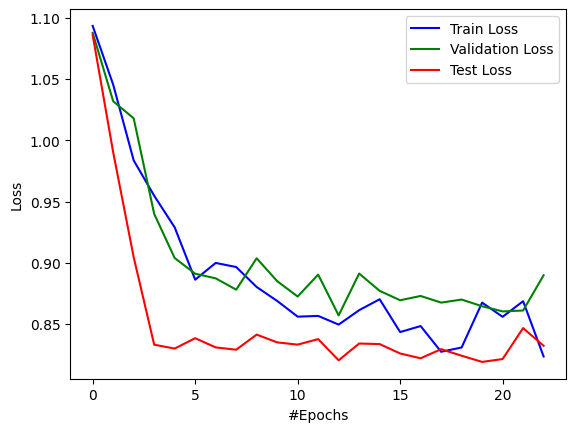

In [12]:
num_epochs = 50
print_interval = 5
learning_rate = 0.0001
batch_size = 256
file_name = "CustomCNN.pt"

network = CNN()

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)

training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_generator = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

trainAndGraph(network, training_generator, val_generator, testing_generator, loss_function, optimizer, num_epochs, early_stopping=True, print_interval=print_interval, fname=file_name, count=6)

Number of parameters:  1816067

Train Set: Accuracy: 3213/4462 (72.0%)

Test Set: Accuracy: 809/1017 (79.5%)


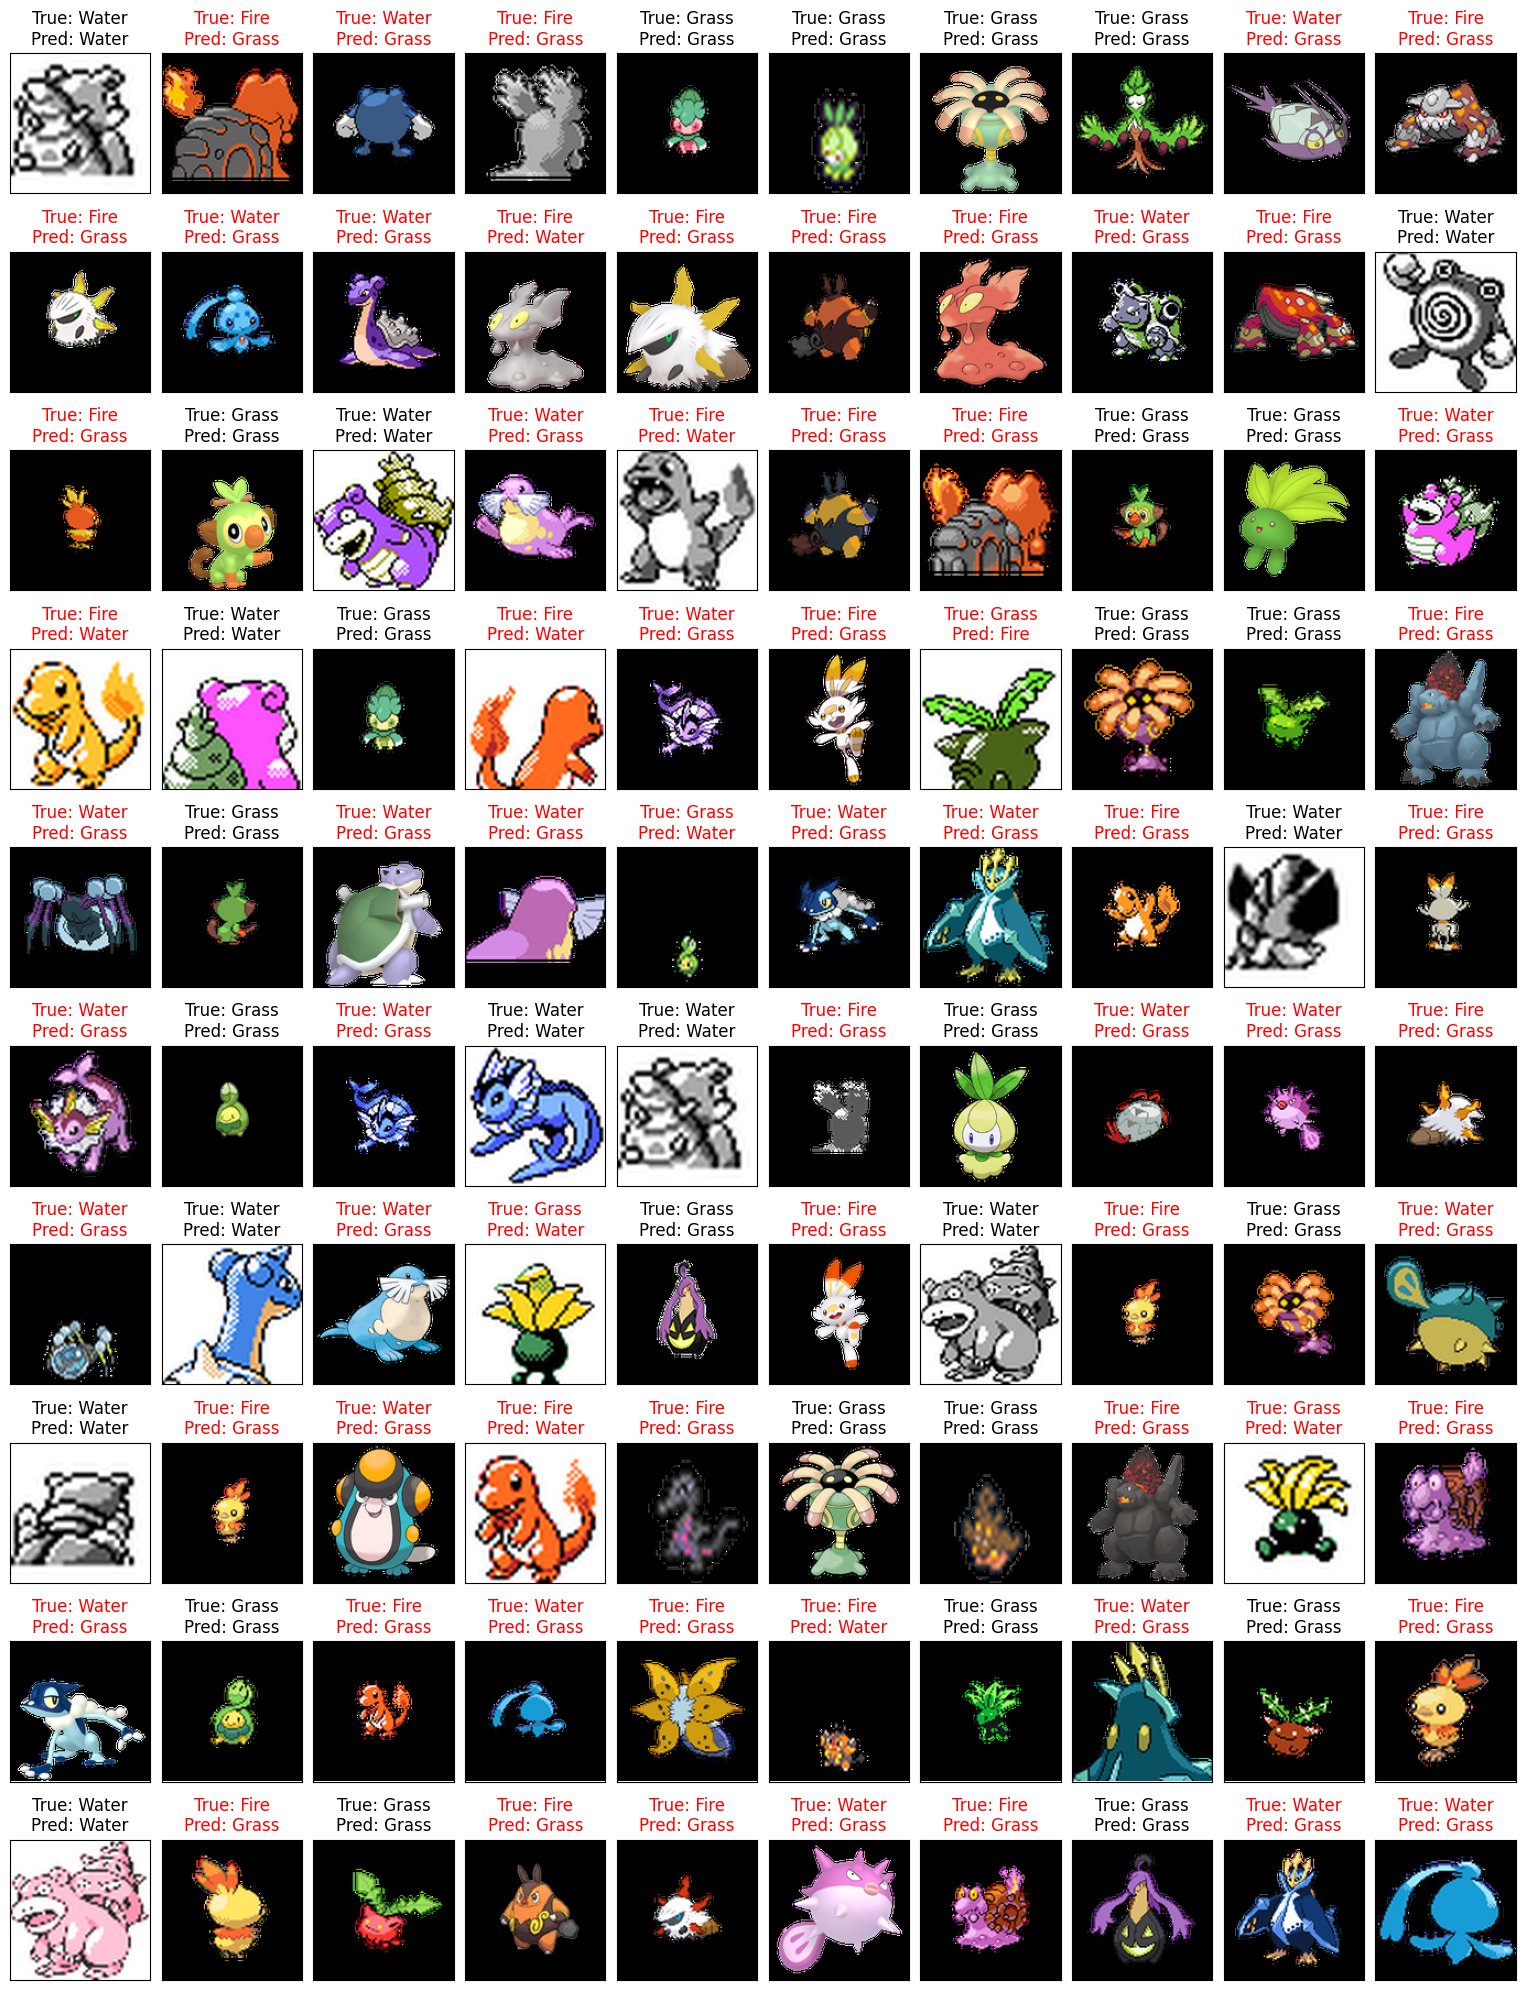

In [30]:
network = CNN()
network.load_state_dict(torch.load(file_name))
network.eval()

num_params = count_parameters(network)
print("Number of parameters: ", num_params)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")

plot_predictions(network, x_test, testing_labels_categories)

## Hybrid CNN

In [9]:
from torchvision.models import resnet18, ResNet18_Weights

class HybridCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridCNN, self).__init__()

        self.img_size = 128

        weights = ResNet18_Weights.DEFAULT
        resnet = resnet18(weights=weights)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: [B, 512, 4, 4]

        # Optional: Freeze early layers
        for param in resnet.parameters():
            param.requires_grad = False
        # for param in resnet.layer4.parameters():  # Fine-tune last block
        #     param.requires_grad = True

        # Dual global pooling
        self.global_avg = nn.AdaptiveAvgPool2d(1)
        self.global_max = nn.AdaptiveMaxPool2d(1)

        # Compact classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
      if len(x.shape) == 2:
            x = x.view(-1, 3, self.img_size, self.img_size)

      x = self.backbone(x)
      avg_pool = self.global_avg(x)
      max_pool = self.global_max(x)
      x = torch.cat([avg_pool, max_pool], dim=1)  # [B, 1024, 1, 1]
      x = x.view(x.size(0), -1)  # Flatten to [B, 1024]
      return self.classifier(x)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


Epoch [1/50], Train Loss: 1.1715, Val Loss: 1.0857, Test Loss: 1.0234
Epoch [6/50], Train Loss: 0.8770, Val Loss: 0.9067, Test Loss: 0.8834
Epoch [11/50], Train Loss: 0.8325, Val Loss: 0.9089, Test Loss: 0.8822
Early stopping: Epoch 14
Testing loss increased from 0.9053 to 0.9167
Best test loss: 0.9036


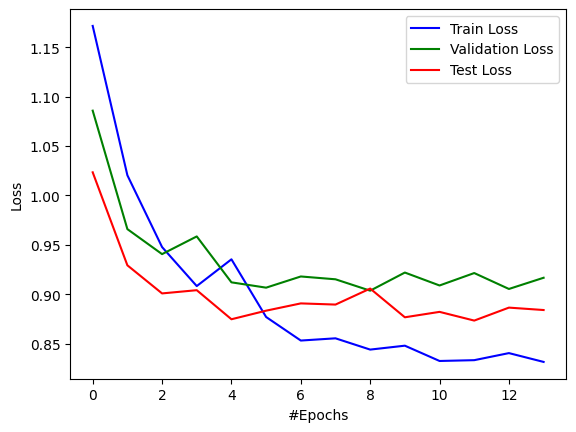

In [15]:
num_epochs = 50
print_interval = 5
learning_rate = 0.0001
batch_size = 256
file_name = "HybridCNN.pt"

network = HybridCNN()

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)

training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_generator = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

trainAndGraph(network, training_generator, val_generator, testing_generator, loss_function, optimizer, num_epochs, early_stopping=True, print_interval=print_interval, fname=file_name)

## Results

In [23]:
def multiple_runs(model_type):
    training_accuracies = []
    testing_accuracies = []

    for i in range(20):
        split_dataset_by_species(data_dir=DATA_PATH + "input_data/", output_dir=DATA_PATH + 'splits/', ratios=(0.7, 0.15, 0.15))
        split_data_directory = DATA_PATH + 'splits/'
        x_train, y_train, x_val, y_val, x_test, y_test, label_encoder = load_pokemon_dataset(split_data_directory, img_size=(128, 128))

        y_train = np.expand_dims(y_train, 1)
        y_test = np.expand_dims(y_test, 1)
        y_val = np.expand_dims(y_val, 1)
        print(y_train.shape)
        print(y_test.shape)
        print(y_val.shape)

        train_transforms = T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=10),
        T.ColorJitter(brightness=0.2, contrast=0.2),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3)
        ])
        test_transforms = T.Compose([
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)
        ])
        training_labels_categories = F.one_hot(torch.tensor(y_train.astype(int)).squeeze()).numpy()
        validation_labels_categories = F.one_hot(torch.tensor(y_val.astype(int)).squeeze()).numpy()
        testing_labels_categories = F.one_hot(torch.tensor(y_test.astype(int)).squeeze()).numpy()

        training_dataset = NumpyDataset(x_train, training_labels_categories, transform=train_transforms)
        validation_dataset = NumpyDataset(x_val, validation_labels_categories, transform=test_transforms)
        testing_dataset = NumpyDataset(x_test, testing_labels_categories, transform=test_transforms)

        batch_size = 256

        if model_type == "CNN":
            file_name = "CustomCNN.pt"
            network = CNN()
        elif model_type == "Hybrid":
            file_name = "HybridCNN.pt"
            network = HybridCNN()

        training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
        testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

        network.load_state_dict(torch.load(DATA_PATH + file_name, map_location=device))
        network.eval()

        training_accuracies.append(computeLabelAccuracy(network, training_generator, "Train Set"))
        testing_accuracies.append(computeLabelAccuracy(network, testing_generator, "Test Set"))
        
        if i == 19:
            num_params = count_parameters(network)
            print("Number of parameters: ", num_params)
            plot_predictions(network, x_test, testing_labels_categories)
            graphConfusionMatrix(testing_dataset, network)

    return training_accuracies, testing_accuracies

In [26]:
def plot_accuracies(training_accuracies, testing_accuracies):
    rows = list(range(1, 21))

    train_acc = [float(t.cpu()) for t in training_accuracies]
    test_acc = [float(t.cpu()) for t in testing_accuracies]

    df = pd.DataFrame({
        'Training Accuracy': train_acc,
        'Testing Accuracy': test_acc
    }, index=rows)

    average_row = pd.DataFrame(df.mean(numeric_only=True)).T
    average_row.index = ['Average']
    df_avg = pd.concat([df, average_row])

    display(df_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Training Accuracy'], marker='o', label='Training Accuracy')
    plt.plot(df.index, df['Testing Accuracy'], marker='s', label='Testing Accuracy', color='red')
    plt.xlabel('Run Number')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy Over 20 Runs')
    plt.legend()
    plt.grid(True)
    plt.show()

### Custom CNN Results

Train set: 4418 images
Validation set: 921 images
Test set: 1004 images
(4418, 1)
(1004, 1)
(921, 1)

Train Set: Accuracy: 2909/4418 (65.8%)

Test Set: Accuracy: 676/1004 (67.3%)
Train set: 4452 images
Validation set: 950 images
Test set: 950 images
(4452, 1)
(950, 1)
(950, 1)

Train Set: Accuracy: 3150/4452 (70.8%)

Test Set: Accuracy: 653/950 (68.7%)
Train set: 4495 images
Validation set: 933 images
Test set: 1011 images
(4495, 1)
(1011, 1)
(933, 1)

Train Set: Accuracy: 3112/4495 (69.2%)

Test Set: Accuracy: 663/1011 (65.6%)
Train set: 4310 images
Validation set: 885 images
Test set: 1073 images
(4310, 1)
(1073, 1)
(885, 1)

Train Set: Accuracy: 2918/4310 (67.7%)

Test Set: Accuracy: 787/1073 (73.3%)
Train set: 4293 images
Validation set: 821 images
Test set: 1169 images
(4293, 1)
(1169, 1)
(821, 1)

Train Set: Accuracy: 3017/4293 (70.3%)

Test Set: Accuracy: 869/1169 (74.3%)
Train set: 4349 images
Validation set: 891 images
Test set: 1140 images
(4349, 1)
(1140, 1)
(891, 1)

Train 

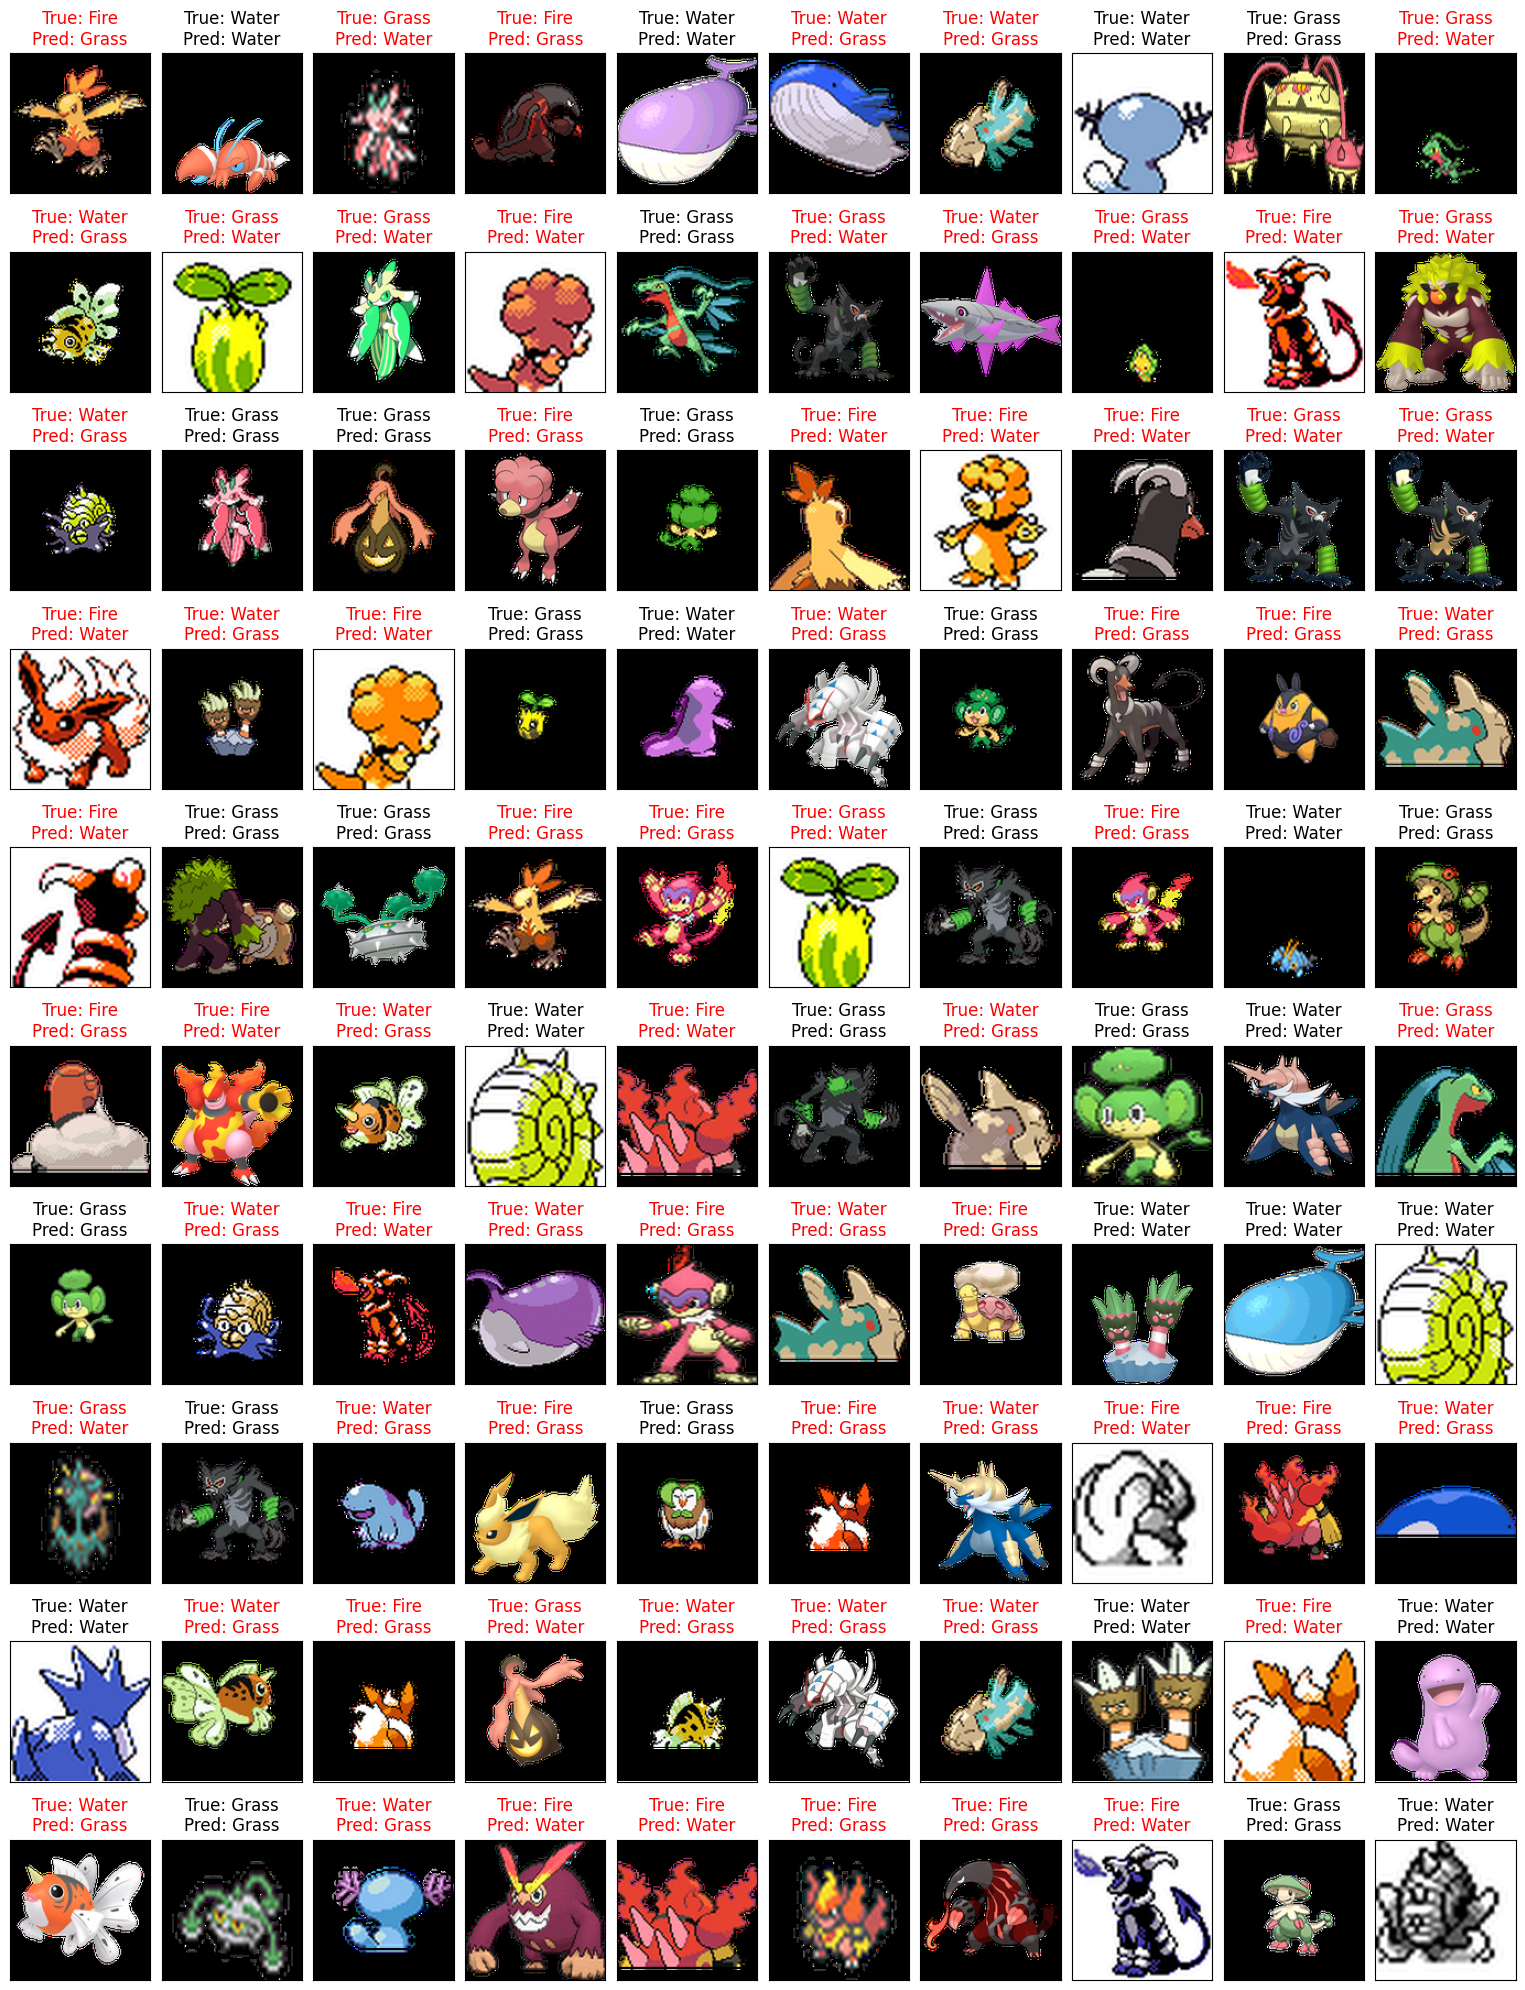

Training Accuracy  Testing Accuracy
1                65.844276         67.330681
2                70.754715         68.736839
3                69.232483         65.578636
4                67.703018         73.345757
5                70.277199         74.337044
6                72.016556         69.035088
7                66.369049         78.522171
8                67.105881         81.170731
9                65.342697         72.324722
10               71.882240         70.849060
11               70.209145         72.347824
12               70.694260         65.250237
13               70.506912         65.004791
14               71.435112         72.062904
15               68.392815         70.039680
16               69.014084         63.412128
17               70.526817         57.932446
18               73.325890         62.570358
19               70.801567         65.349030
20               66.077896         77.601585
Average          69.375631         69.640086

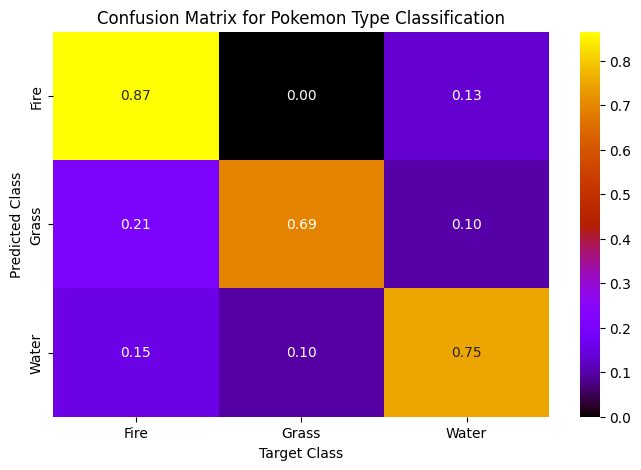

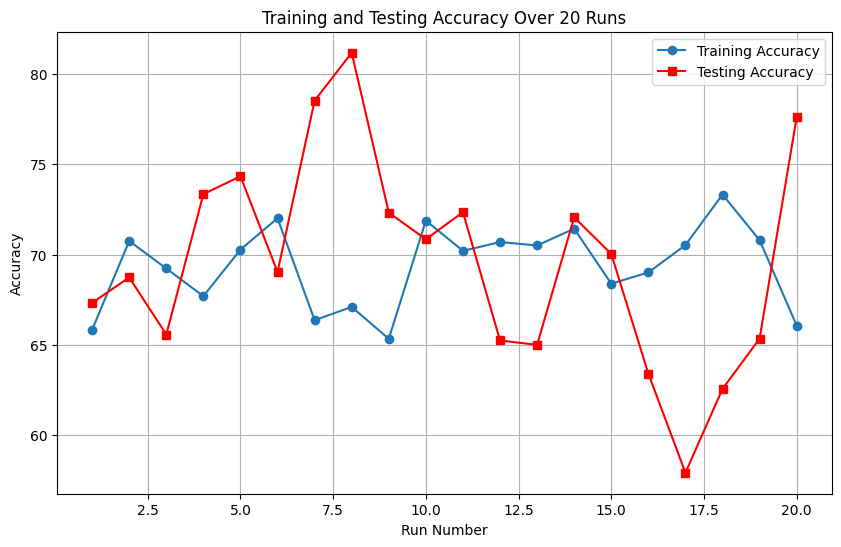

In [27]:
training_accs, testing_accs = multiple_runs("CNN")
plot_accuracies(training_accs, testing_accs)

### Hybrid CNN Results

Train set: 4324 images
Validation set: 935 images
Test set: 920 images
(4324, 1)
(920, 1)
(935, 1)

Train Set: Accuracy: 2796/4324 (64.7%)

Test Set: Accuracy: 578/920 (62.8%)
Train set: 4345 images
Validation set: 859 images
Test set: 1059 images
(4345, 1)
(1059, 1)
(859, 1)

Train Set: Accuracy: 2737/4345 (63.0%)

Test Set: Accuracy: 717/1059 (67.7%)
Train set: 4384 images
Validation set: 893 images
Test set: 1189 images
(4384, 1)
(1189, 1)
(893, 1)

Train Set: Accuracy: 2815/4384 (64.2%)

Test Set: Accuracy: 714/1189 (60.1%)
Train set: 4388 images
Validation set: 1014 images
Test set: 1067 images
(4388, 1)
(1067, 1)
(1014, 1)

Train Set: Accuracy: 2908/4388 (66.3%)

Test Set: Accuracy: 686/1067 (64.3%)
Train set: 4153 images
Validation set: 978 images
Test set: 1104 images
(4153, 1)
(1104, 1)
(978, 1)

Train Set: Accuracy: 2781/4153 (67.0%)

Test Set: Accuracy: 704/1104 (63.8%)
Train set: 4352 images
Validation set: 991 images
Test set: 1046 images
(4352, 1)
(1046, 1)
(991, 1)

Trai

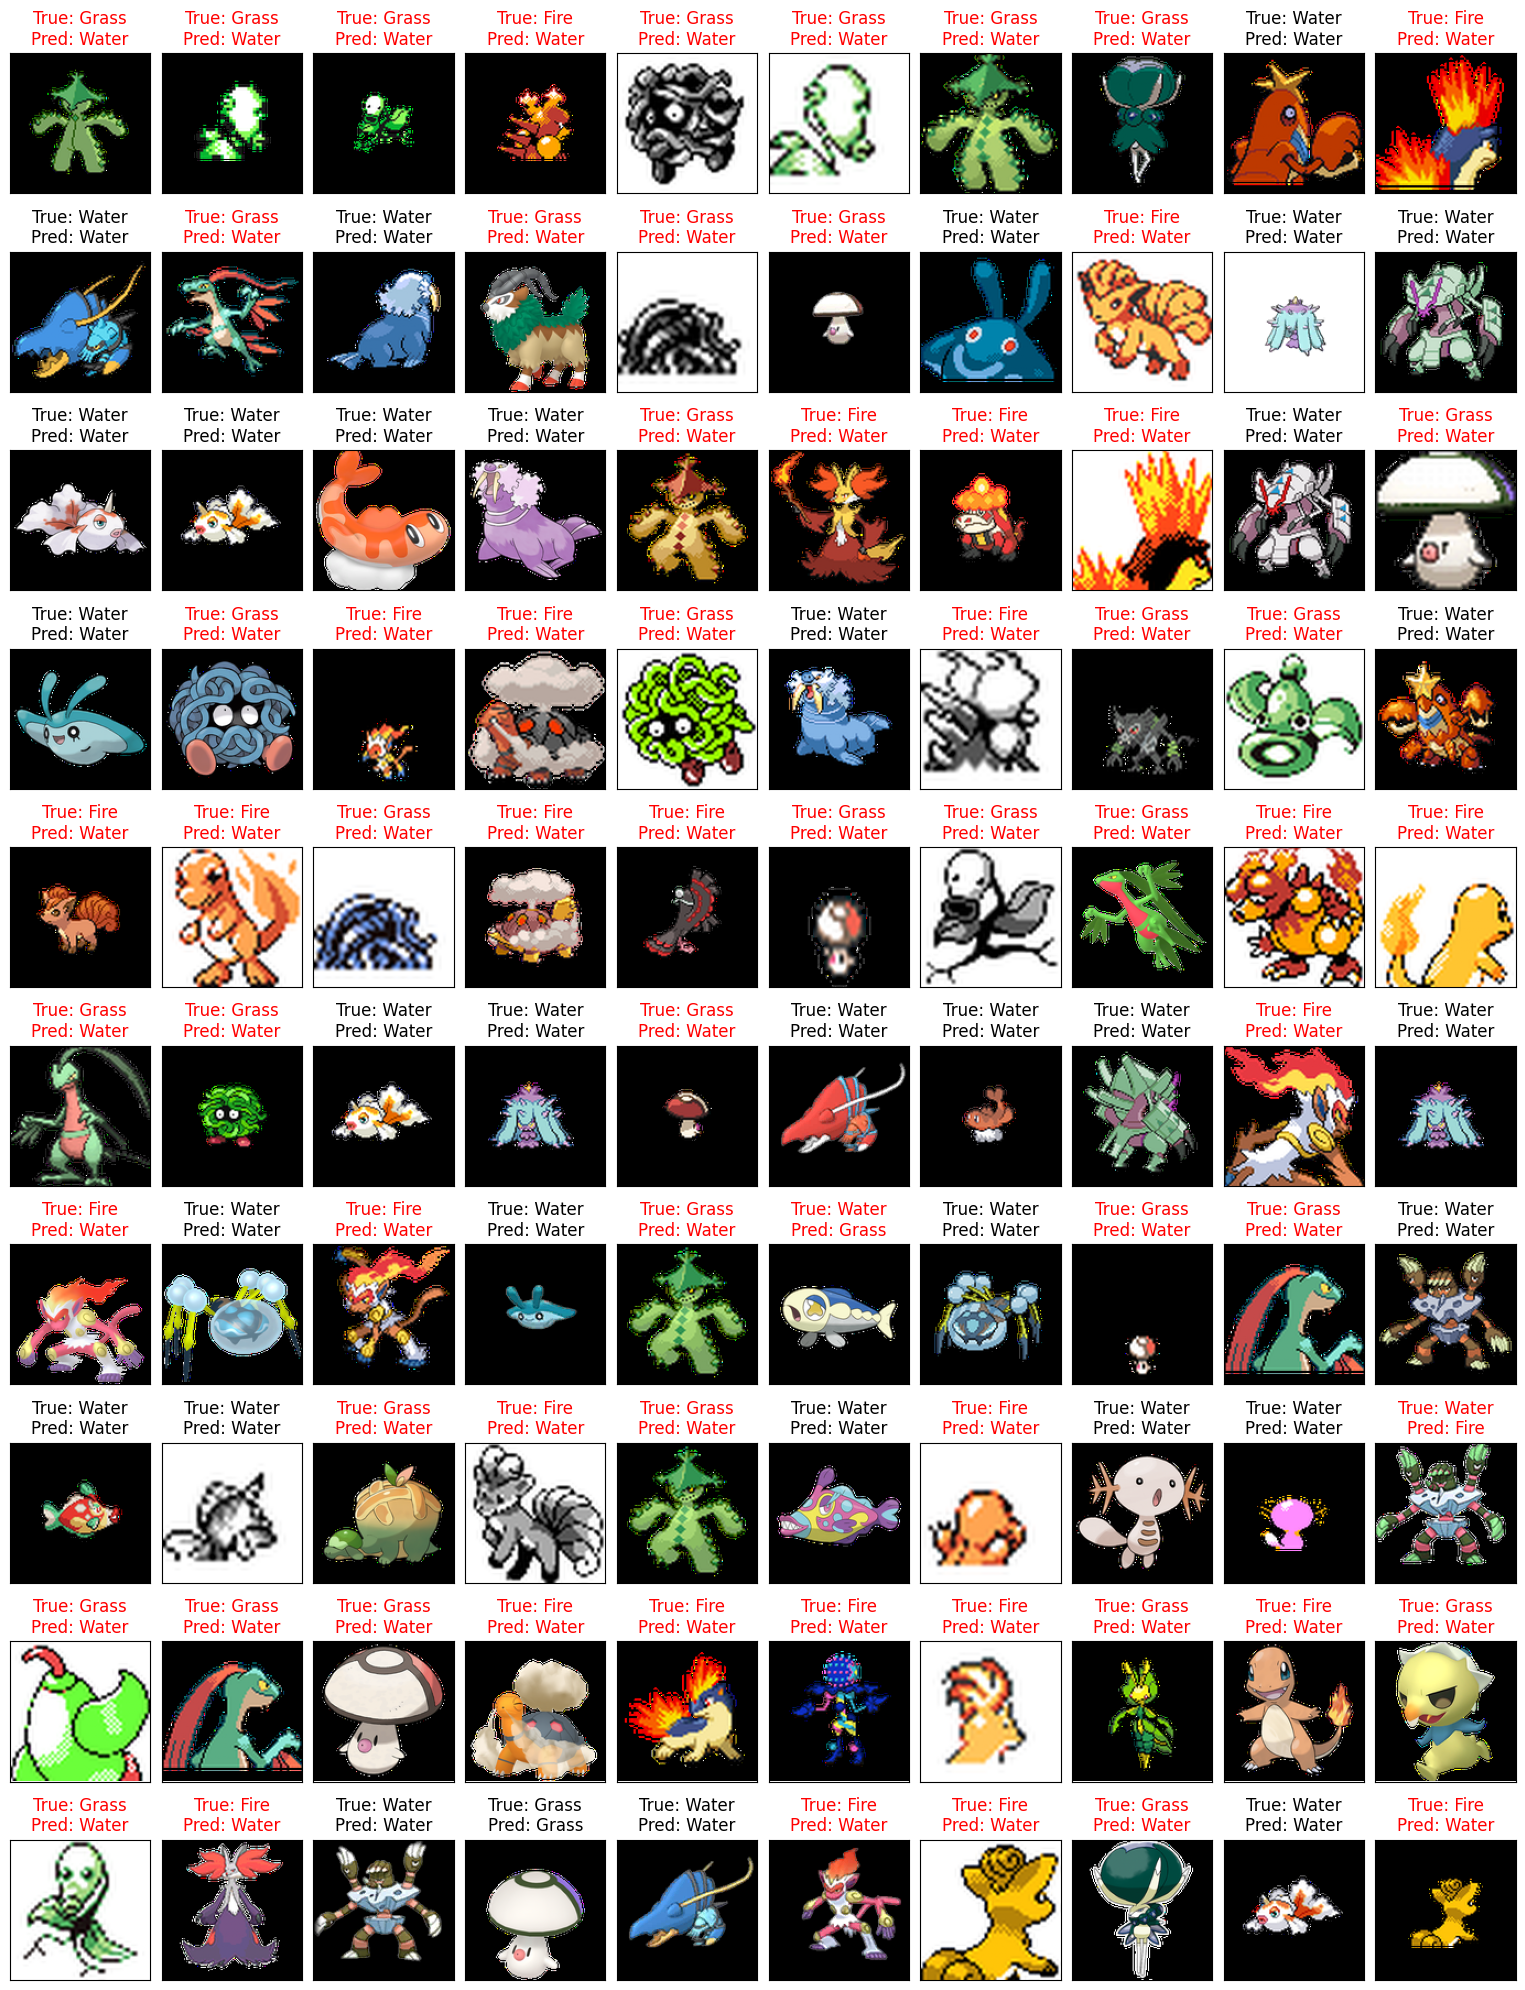

Training Accuracy  Testing Accuracy
1                64.662346         62.826088
2                62.991943         67.705383
3                64.210770         60.050461
4                66.271652         64.292412
5                66.963638         63.768116
6                65.785843         68.738052
7                63.605053         60.076775
8                65.132362         63.575043
9                63.863003         65.317917
10               65.618637         57.398212
11               66.297577         55.555557
12               63.636364         68.559410
13               63.999062         58.529945
14               63.860226         63.026051
15               67.224457         69.070206
16               68.244308         60.057198
17               61.583508         67.911880
18               65.143784         64.322647
19               66.444191         64.401917
20               64.369156         61.505833
Average          64.995394         63.334455

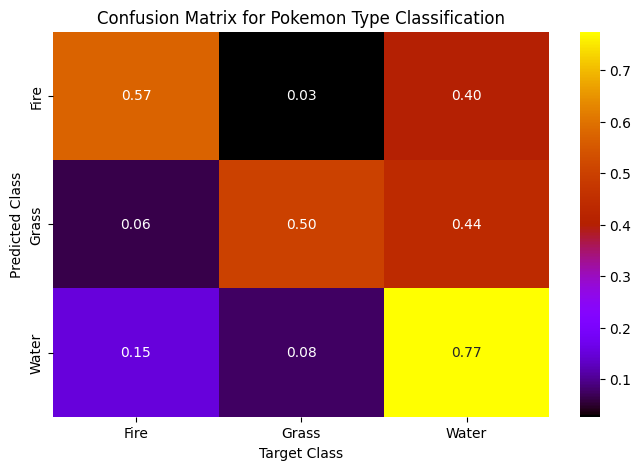

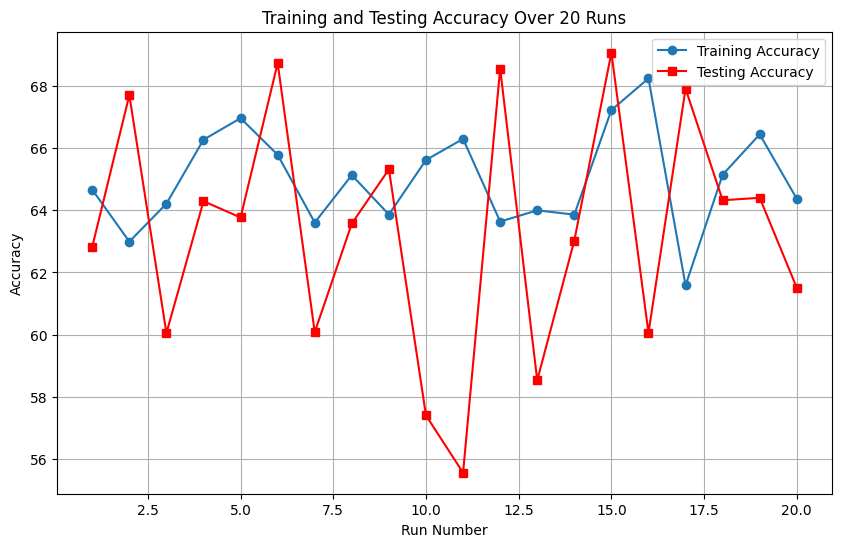

In [28]:
training_accs, testing_accs = multiple_runs("Hybrid")
plot_accuracies(training_accs, testing_accs)